# QUBO solved by DWave

https://arxiv.org/ftp/arxiv/papers/1811/1811.11538.pdf

For a Minimum Vertex Cover (MVC) problem on a weighted graph $ G_w = (V_w,E) $ with $ V_w $ weighted vertices, $ E $ edges, where one also wishes to maximize the weights of the selected nodes and respect a size constraint, the QUBO formulation can be structured as follows:

1. **Variables:** For each node $ i $, a binary variable $ x_i $ is defined, where $ x_i = 1 $ if node $ i $ is selected in the cover, and 0 otherwise.
2. **Coverage Constraint:** Each edge must be covered by at least one of the nodes it connects (MVC).
3. **Node Weights:** Each node $ i $ has a weight $ w_i $.
4. **Size Constraint:** Impose a maximum size $ k $ on the number of selected nodes.

The QUBO objective function can be expressed as minimize :

$ f(x) = - \sum_{i=1}^V w_i x_i + A \sum_{(i, j) \in E} (1 - x_i)(1 - x_j) + B \left( \sum_{i=1}^V x_i - k \right)^2 $

For a linear graph of 3 nodes (1 ----- 2 ----- 3) the QUBO matrix would be: 

|          | $ x_1 $                               | $ x_2 $                                | $ x_3 $                                |
|----------|---------------------------------------|----------------------------------------|----------------------------------------|
| $ x_1 $  | $ - w_1 - A + B(1 - 2k) $             | $ A + 2B$                              | $2B$                                   |
| $ x_2 $  | $  A + 2B$                            | $ - w_2 - 2A + B(1 - 2k) $             | $ A + 2B$                              |
| $ x_3 $  | $2B$                                  | $ A + 2B$                              | $ - w_3 - A + B(1 - 2k) $              |

The values of $ A $ and $ B $ must be carefully chosen to balance the maximization of the weights of the nodes, the coverage of each edge, and the size constraint of the MVC.



In [11]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np

from dwave.system import DWaveSampler, EmbeddingComposite
from dwave.cloud import Client

In [12]:

def create_qubo_matrix(graph, A, B, k):
    """
    Create a 2D QUBO matrix for the weighted MVC problem with a size constraint on a given graph.

    :param graph: NetworkX graph
    :param A: Coefficient for the edge coverage penalty
    :param B: Coefficient for the size constraint penalty
    :param k: Size constraint (number of vertices to be included in the vertex cover)
    :return: QUBO matrix as a 2D numpy array
    """
    n = len(graph)
    Q = np.zeros((n, n))

    for i in range(n):
        # Weight constrainte
        Q[i][i] -= graph.nodes[i]['weight']
        # Size constrainte (diag)
        Q[i][i] += B * (1 - 2 * k)  
        for j in range(i + 1, n):
            # Size constrainte (off-diag)
            Q[i][j] += 2 * B
            Q[j][i] += 2 * B
            if graph.has_edge(i, j):
                # MVC consctrainte (diag)
                Q[i][i] -= A
                Q[j][j] -= A
                # MVC consctrainte (off-diag)
                Q[i][j] += A
                Q[j][i] += A


    return Q

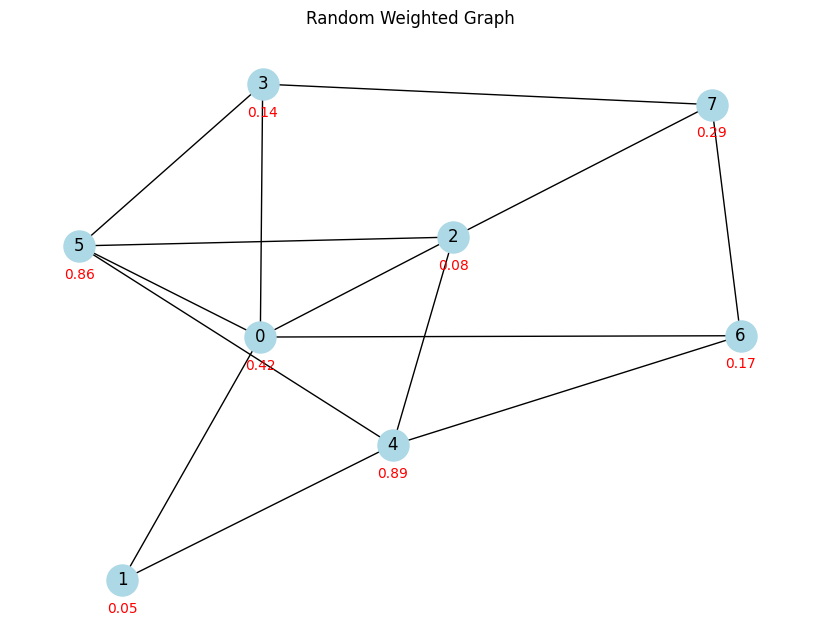

array([[ 6.91538309, -2.        , -2.        , -2.        , -1.        ,
        -2.        , -2.        , -1.        ],
       [-2.        ,  3.5540847 , -1.        , -1.        , -2.        ,
        -1.        , -1.        , -1.        ],
       [-2.        , -1.        ,  5.57632951, -1.        , -2.        ,
        -2.        , -1.        , -2.        ],
       [-2.        , -1.        , -1.        ,  4.637935  , -1.        ,
        -2.        , -1.        , -2.        ],
       [-1.        , -2.        , -2.        , -1.        ,  6.39412976,
        -2.        , -2.        , -1.        ],
       [-2.        , -1.        , -2.        , -2.        , -2.        ,
         6.35621181, -1.        , -1.        ],
       [-2.        , -1.        , -1.        , -1.        , -2.        ,
        -1.        ,  4.67213838, -2.        ],
       [-1.        , -1.        , -2.        , -2.        , -1.        ,
        -1.        , -2.        ,  4.78754955]])

In [16]:
# Example usage
n = 8  # Number of nodes
A = 1  # Edge coverage penalty coefficient
B = 0.5  # Size constraint penalty coefficient
k = 2  # Size constraint

# Create a random weighted graph
G = nx.Graph()
G.add_nodes_from(range(n))
for i in range(n):
    for j in range(i + 1, n):
        if random.random() < 0.5:  # Randomly decide whether to add an edge
            G.add_edge(i, j)
    G.nodes[i]['weight'] = random.uniform(0, 1)  # Assign random weights to the nodes

# Create the QUBO matrix as a 2D numpy array
QUBO_MATRIX = create_qubo_matrix(G, A, B, k)

# Plot the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)  
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500)
labels = nx.get_node_attributes(G, 'weight')
for node, label in labels.items():
    x, y = pos[node]
    plt.text(x, y-0.1, f'{label:.2f}', horizontalalignment='center', verticalalignment='center', color='red')

plt.title("Random Weighted Graph")
plt.show()

QUBO_MATRIX

D-WAVE resolution

s'enregistrer : https://cloud.dwavesys.com/leap/

penser a mettre dans le bashrc :

export DWAVE_API_TOKEN='DEV-3c2720060b258ccc9221669519ef5f1d0eb3fa09'

mettre son propre token
penser a relancer le terminal apres avoir enregistrer le bashrc

In [14]:

with Client.from_config() as client:
    print(client.get_solvers())

[BQMSolver(id='hybrid_binary_quadratic_model_version2'), DQMSolver(id='hybrid_discrete_quadratic_model_version1'), CQMSolver(id='hybrid_constrained_quadratic_model_version1'), StructuredSolver(id='Advantage2_prototype1.1'), StructuredSolver(id='Advantage_system6.3'), StructuredSolver(id='Advantage_system4.1')]


In [15]:
# Configurer le sampler
sampler = EmbeddingComposite(DWaveSampler())

# Résoudre le problème QUBO
response = sampler.sample_qubo(QUBO_MATRIX)

# Afficher les résultats
for sample, energy in response.data(['sample', 'energy']):
    print("Solution:", sample, "Energy:", energy)

Solution: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1} Energy: -39.247708133257035
